<a href="https://colab.research.google.com/github/aquapathos/TFLesson/blob/master/TSP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

# import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,UpSampling2D,Conv2DTranspose,BatchNormalization
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, CSVLogger
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

import tensorflow.compat.v1 as tf

Using TensorFlow backend.


# TSPの最適解生成のためのプログラム導入（concorde法）
- https://github.com/jvkersch/pyconcorde のプログラムを使わせていただく

In [2]:
!git clone https://github.com/jvkersch/pyconcorde
% cd pyconcorde
!pip install -e .

fatal: destination path 'pyconcorde' already exists and is not an empty directory.
/content/pyconcorde
Obtaining file:///content/pyconcorde
  Found existing installation: pyconcorde 0.1.0
    Can't uninstall 'pyconcorde'. No files were found to uninstall.
  Running setup.py develop for pyconcorde


# 巡回地点の生成

In [0]:
CSIZE = 7 # 最小セルサイズ
MSIZE = 2 # 周辺にとるマージン 
GFACTOR = 5

In [0]:
# 巡回する点を生成する関数
#　入力
# 　pnum : 巡回ポイント数
# 　(xsize,ysize) : エリアのサイズ
# 　msize : 周辺に残すマージン
# 　ksize : 入力画像をぼかした画像を作る際のガウスぼかしのカーネルサイズ
#　出力
#  1. posA 座標の numpy 配列
#  2. tspimg 訪問地点を白画素とした画像
#  3. btspimg 上の画像をガウスぼかしした画像
#  4. 表示用の参照画像

def genTSP(pnum = 3, xsize=CSIZE,ysize=CSIZE, msize = MSIZE,ksize=GFACTOR):
  tspimg = np.zeros((ysize,xsize),np.uint8)
  refimg = np.ones((ysize,xsize,3),np.uint8)*200
  posnumA = []
  def genPnum(pset=posnumA): # 既存の集合に存在しない整数乱数を１つ生成　して集合に追加して返す    
    while True:
      a = np.random.randint(0,(xsize-2*msize)*(ysize-2*msize))
      if a not in pset:
            pset.append(a)
            break              
    return pset
  
  while len(posnumA) < pnum:
    posnumA = genPnum(pset=posnumA)
 
  posA = []
  for i,n in enumerate(posnumA):
    y = n//(xsize-2*msize)+msize
    x = n%(xsize-2*msize)+msize
    posA.append([x,y])
    tspimg[y,x]=255
    cv2.circle(refimg,(x,y),msize//2,(0,0,255),-1)
  ksize = 2*msize*GFACTOR+1
  btspimg = cv2.GaussianBlur(tspimg,(ksize,ksize),0)
  btspimg = (btspimg/btspimg.max())*255
  return np.array(posA),tspimg,btspimg,refimg

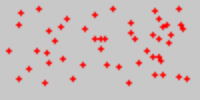

巡回地点マップ(表示用)


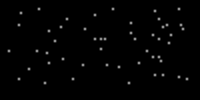

巡回地点マップ（出題用）


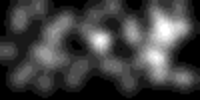

巡回地点密度マップ（ガウシアンフィルタでぼかしたマップ）


In [5]:
poss, img, bimg, rimg = genTSP(pnum=50,xsize=100,ysize=50)
cv2_imshow(cv2.resize(rimg,(200,100)))
print("巡回地点マップ(表示用)")
cv2_imshow(cv2.resize(img,(200,100)))
print("巡回地点マップ（出題用）")
cv2_imshow(cv2.resize(bimg,(200,100)))
print("巡回地点密度マップ（ガウシアンフィルタでぼかしたマップ）")  # ぼかした画像は使うかどうかあとで考える。

# TSPの学習用データの生成（concorde法）
- https://github.com/jvkersch/pyconcorde のプログラムを使わせていただく

# 解が生成できることの確認

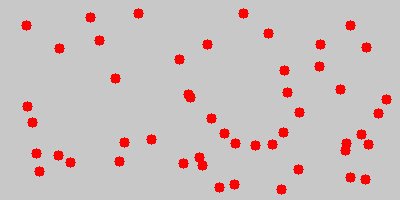

[ 0  7 39 17 21 29 49 35 23 41 30 14 20 42 40 16 47  4 33 15  5 31 22 38
 27  1 44 10  2 32 12 26  3 34  6 43 36 11 46 13 45  9  8 37 19 24 48 28
 25 18] tour length 1545.0


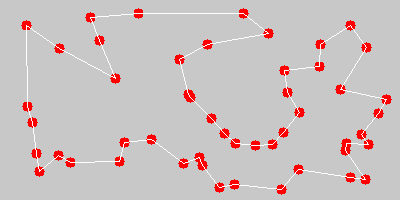

In [6]:
from concorde.tsp import TSPSolver
from concorde.tests.data_utils import get_dataset_path

poss, img, bimg, rimg = genTSP(pnum=50,xsize=400,ysize=200,msize=10)
cv2_imshow(rimg)

# 地点データをx座標とy座標に分離
xs = [x for [x,y] in poss]
ys = [y for [x,y] in poss]

# concorde ソルバーの準備　距離は２次元ユークリッド距離
solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")

# TSPを解く
solution = solver.solve()

color = rimg.copy()
ps = solution.tour

# 巡回順に白線で結ぶ
cv2.line(color,(xs[ps[0]],ys[ps[0]]),(xs[ps[-1]],ys[ps[-1]]),(255,255,255),1)
p0 = ps[0]
for p1 in ps[1:]:
  color = cv2.line(color,(xs[p0],ys[p0]),(xs[p1],ys[p1]),(255,255,255),1)
  p0 = p1
print(solution.tour, "tour length",solution.optimal_value)
cv2_imshow(color)

# 追確認

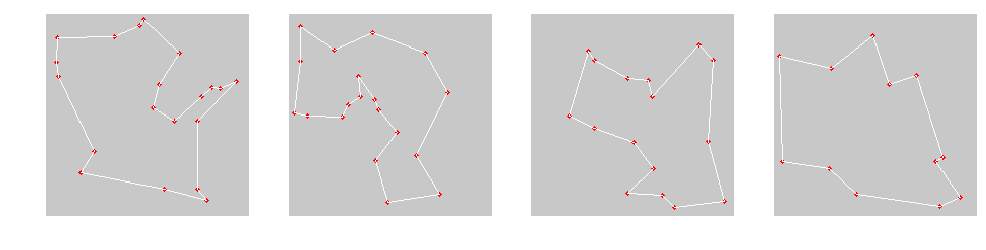

In [7]:
plt.figure(figsize=(12, 6), dpi=100)
for i in range(4):
    plt.subplot(1, 4, i+1)
    poss, img, bimg,rimg = genTSP(pnum=np.random.randint(10,25),xsize=200,ysize=200,msize=5)
    xs = [x for [x,y] in poss]
    ys = [y for [x,y] in poss]
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    ps = solution.tour
    cv2.line(rimg,(xs[ps[0]],ys[ps[0]]),(xs[ps[-1]],ys[ps[-1]]),(255,255,255),1)
    p0 = ps[0]
    for p1 in ps[1:]:
      rimg = cv2.line(rimg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),(255,255,255),1)
      p0 = p1
    plt.imshow(rimg[:,:,::-1])
    plt.axis('off')

# 基礎実験
- セルサイズ 24*24
-200個の問題を生成
- X：入力の配列
- Y：理想解の配列

In [0]:
X,Y,Xb,Xr,Sols = [],[],[],[],[]
Poss = []
for i in range(200):
    data, img, bimg,rimg = genTSP(pnum=np.random.randint(10,25),xsize=24,ysize=24,msize=1)
    Poss.append(data)
    X.append(img)
    Xb.append(bimg)
    Xr.append(rimg)
    xs = [x for [x,y] in data]
    ys = [y for [x,y] in data]
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    simg = np.zeros_like(img)
    ps = solution.tour
    Sols.append(ps)
    cv2.line(simg,(xs[ps[0]],ys[ps[0]]),(xs[ps[-1]],ys[ps[-1]]),255,1)
    p0 = ps[0]
    for p1 in ps[1:]:
      simg = cv2.line(simg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),255,1)
      p0 = p1
    Y.append(simg)

# 確認
200のうちの先頭50個だけ表示してみる

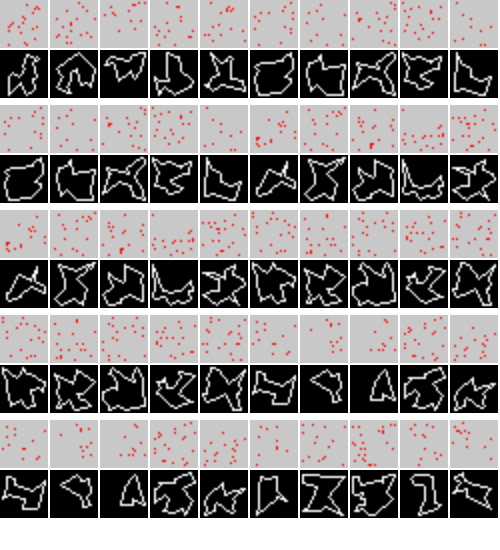

<Figure size 1200x600 with 0 Axes>

In [9]:
plt.figure(figsize=(12, 6), dpi=100)
simg = np.ones((550,500,3),np.uint8)*255
for i in range(5):
  for j in range(10):
    simg[105*i:105*i+48,50*j:50*j+48,:] = cv2.resize(Xr[5*i+j],(48,48))
    simg[105*i+50:105*i+98,50*j:50*j+48] = cv2.resize(cv2.cvtColor(Y[5*i+j],cv2.COLOR_GRAY2BGR),(48,48))
cv2_imshow(simg)

In [10]:
Poss[100] # 100番の課題

array([[21, 17],
       [12,  2],
       [15,  4],
       [ 9, 18],
       [ 8, 10],
       [18,  5],
       [ 5, 14],
       [14, 12],
       [ 7, 22],
       [ 6,  6],
       [ 2, 10],
       [ 4,  6],
       [22,  1],
       [22, 17],
       [22, 10],
       [18,  9],
       [ 9, 12],
       [18,  2],
       [ 7, 15],
       [ 1,  1],
       [ 5, 17],
       [ 1, 17]])

# データの水増し1
反転と回転で１つの問題を８倍に水増しする  
[[1, 2, 3],  
 [4, 5, 6],   
 [7, 8, 9]])  
- flip axis=0 上下反転  
[[7 8 9]  
 [4 5 6]  
 [1 2 3]]  
- flip axis=1 左右反転  
[[3 2 1]  
 [6 5 4]  
 [9 8 7]]  
- flip axis=None  
[[9 8 7]  
 [6 5 4]  
 [3 2 1]]  
- rot90  k=1 反時計回り90度   
[[3 6 9]  
 [2 5 8]  
 [1 4 7]]  
- rot90 k=1 , flip axis=0  
[[1 4 7]  
 [2 5 8]  
 [3 6 9]]  
- rot90  k=-1  時計回り90度  
[[7 4 1]  
 [8 5 2]  
 [9 6 3]]  
- rot90 k=-1 , flip axis=0  
[[9 6 3]  
 [8 5 2]  
 [7 4 1]]  

- http://pynote.hatenablog.com/entry/numpy-array-manipulation-functions

In [0]:
for i in range(200):
  x,y = X[i],Y[i]
  X.append(np.flip(x,axis=0))
  Y.append(np.flip(y,axis=0))
  Poss.append([[a,24-b] for [a,b] in Poss[i]])
  Sols.append(Sols[i])
  X.append(np.flip(x,axis=1))
  Y.append(np.flip(y,axis=1))
  Poss.append([[a,24-b] for [a,b] in Poss[i]])
  Sols.append(Sols[i])
  X.append(np.flip(x,axis=None))
  Y.append(np.flip(y,axis=None))
  Poss.append([[24-a,24-b] for [a,b] in Poss[i]])
  Sols.append(Sols[i])
  X.append(np.rot90(x,k=1))
  Y.append(np.rot90(y,k=1))
  Poss.append([[b,24-a] for [a,b] in Poss[i]])
  Sols.append(Sols[i])
  X.append(np.flip(X[-1],axis=0))
  Y.append(np.flip(Y[-1],axis=0))
  Poss.append([[b,a] for [a,b] in Poss[i]])
  Sols.append(Sols[i])
  X.append(np.rot90(x,k=-1))
  Y.append(np.rot90(y,k=-1)) 
  Poss.append([[24-b,a] for [a,b] in Poss[i]])
  Sols.append(Sols[i])
  X.append(np.flip(X[-1],axis=0))
  Y.append(np.flip(Y[-1],axis=0))
  Poss.append([[24-b,24-a] for [a,b] in Poss[i]])
  Sols.append(Sols[i])

# データの水増し２
1. 縦横２倍（48x48）のエリアに、(24x24)の各問題を24ピクセルずつ縦横移動して貼り付けた問題を作り、９倍に水増しする
2. 24x24の問題の訪問地点の位置を縦横２倍に拡大して　48x48 の問題を作る。
上の２つの操作で10倍に水増し。

In [0]:
Xex, Yex, PossEx,SolsEx = [],[],[],[]
for x,y,p,sol in zip(X,Y,Poss,Sols):
  for s in range(0,25,12):
    for t in range(0,25,12):
      x1 = np.zeros((48,48),np.uint8)
      y1 = np.zeros((48,48),np.uint8)
      x1[s:s+24,t:t+24] = x
      y1[s:s+24,t:t+24] = y
      Xex.append(x1)
      Yex.append(y1)
      PossEx.append([(px+s,py+t) for [px,py] in p])
      SolsEx.append(sol)
      
  x1 = np.zeros((48,48),np.uint8)
  y1 = np.zeros((48,48),np.uint8)
  for index,[px,py] in enumerate(p):
    p[index]=[2*px,2*py]
    x1[2*py,2*px] = 255
  Xex.append(x1)
  PossEx.append(p)
  SolsEx.append(sol)
  cv2.line(y1,(p[sol[0]][0],p[sol[0]][1]),(p[sol[-1]][0],p[sol[-1]][1]),255,1)
  p0 = sol[0]
  for p1 in sol[1:]:
    cv2.line(y1,(p[p0][0],p[p0][1]),(p[p1][0],p[p1][1]),255,1)
    p0 = p1
  Yex.append(y1)

# サンプルで確認

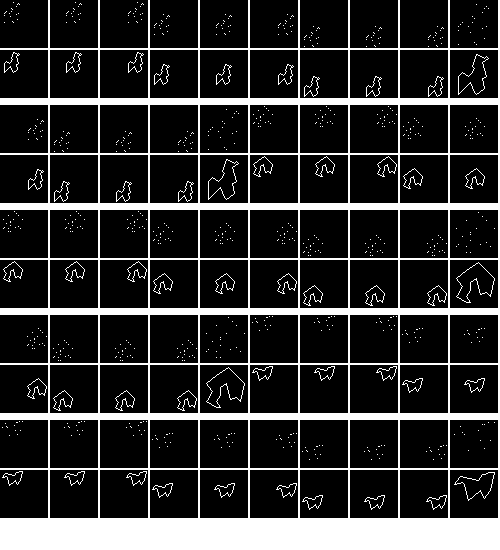

<Figure size 1200x600 with 0 Axes>

In [13]:
plt.figure(figsize=(12, 6), dpi=100)
simg = np.ones((550,500),np.uint8)*255
for i in range(5):
  for j in range(10):
    simg[105*i:105*i+48,50*j:50*j+48] = Xex[5*i+j]
    simg[105*i+50:105*i+98,50*j:50*j+48] = Yex[5*i+j]
cv2_imshow(simg)

In [14]:
session = tf. Session ('')     # tensorboardを使うのに必要な設定
KTF.set_session (session)      # tensorboardをわないなら不要
KTF.set_learning_phase (1)     # 

model = Sequential()
model.add(Conv2D(64,kernel_size=(5, 5),padding='same',
                 activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(7, 7),padding='same',
                 activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(MaxPooling2D(pool_size=(2, 2)),)
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Conv2D(64,kernel_size=(7, 7),padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2DTranspose(64, kernel_size=5,  activation='relu', use_bias=False))
model.add(Conv2DTranspose(64, kernel_size=5,  activation='relu', use_bias=False))
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(64, kernel_size=5,  activation='relu', use_bias=False))
model.add(Conv2DTranspose(32, kernel_size=5,  activation='relu', use_bias=False))
model.add(Conv2DTranspose(1, kernel_size=1,  activation='relu',use_bias=False))

model.summary()

W0616 14:28:08.091824 140349930018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 14:28:08.094732 140349930018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 14:28:08.098808 140349930018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 14:28:08.134799 140349930018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 14:28:08.136194 140349930

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        200768    
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
__________

In [15]:
model.compile(loss= 'binary_crossentropy', # 'mean_squared_error',
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              #optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

W0616 14:28:09.073811 140349930018688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 14:28:09.088105 140349930018688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
dsize = len(Xex)
batch_size = 1000
epochs = 20

X1 = np.array(Xex).reshape(dsize,48*48).astype('float32')
X1 = X1/255
X1 = X1.reshape(-1,48,48,1)
Y1 = np.array(Yex).reshape(dsize,48*48)
Y1 = Y1/255
Y1 = Y1.reshape(-1,48,48,1)

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.2, # 20 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                  callbacks=[es, csv_logger])

Train on 12800 samples, validate on 3200 samples
Epoch 1/20
12800/12800 [==============================] - 24s 2ms/step - loss: 0.1090 - acc: 0.9661 - val_loss: 0.1065 - val_acc: 0.9662
Epoch 2/20
12800/12800 [==============================] - 24s 2ms/step - loss: 0.1052 - acc: 0.9661 - val_loss: 0.1038 - val_acc: 0.9662
Epoch 3/20
12800/12800 [==============================] - 24s 2ms/step - loss: 0.1018 - acc: 0.9661 - val_loss: 0.1001 - val_acc: 0.9662
Epoch 4/20
12800/12800 [==============================] - 24s 2ms/step - loss: 0.0992 - acc: 0.9661 - val_loss: 0.0986 - val_acc: 0.9662
Epoch 5/20
12800/12800 [==============================] - 24s 2ms/step - loss: 0.0975 - acc: 0.9661 - val_loss: 0.0968 - val_acc: 0.9662
Epoch 6/20
12800/12800 [==============================] - 24s 2ms/step - loss: 0.0963 - acc: 0.9661 - val_loss: 0.0955 - val_acc: 0.9662
Epoch 7/20
12800/12800 [==============================] - 24s 2ms/step - loss: 0.0950 - acc: 0.9661 - val_loss: 0.0944 - val_acc:

In [0]:
def test():
    data, img, bimg,rimg = genTSP(pnum=np.random.randint(10,25),xsize=48,ysize=48,msize=1)
    img2 = img.reshape((1,48,48,1))
    output = model.predict(img2)
    output = np.ndarray.flatten(output)
    output = output.reshape((48,48))
    
    xs = [x for [x,y] in data]
    ys = [y for [x,y] in data]
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    simg = np.zeros_like(img)
    ps = solution.tour
    Sols.append(ps)
    cv2.line(simg,(xs[ps[0]],ys[ps[0]]),(xs[ps[-1]],ys[ps[-1]]),255,1)
    p0 = ps[0]
    for p1 in ps[1:]:
      simg = cv2.line(simg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),255,1)
      p0 = p1    

    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,4,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-img,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,4,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(1-output,cmap=plt.cm.binary)
    subplot = fig.add_subplot(1,4,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(255-simg,cmap=plt.cm.binary)

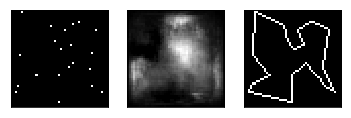

In [18]:
test()

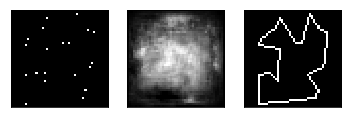

In [19]:
test()

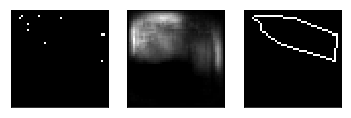

In [20]:
test()

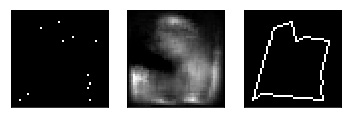

In [21]:
test()

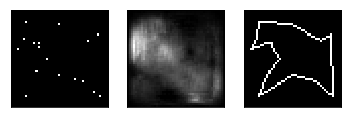

In [22]:
test()

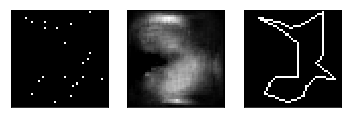

In [23]:
test()

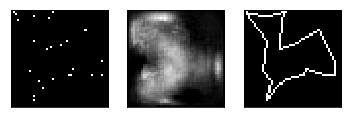

In [24]:
test()

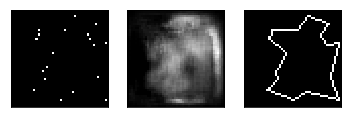

In [25]:
test()

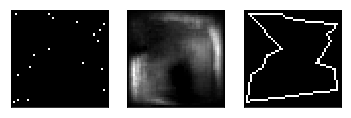

In [26]:
test()